# Classificação de Direção de Ações Brasileiras com Machine Learning

Este notebook apresenta um pipeline completo de classificação para prever a direção da variação percentual diária do preço de fechamento de ações brasileiras. Utilizaremos dados históricos de cinco ativos: BBAS3, EMBR3, KLBN3, PETR4, TOTS3, VIVA3. O objetivo é construir e comparar modelos capazes de prever se a variação do próximo dia será positiva (alta) ou negativa (baixa).

## 1. Carregamento e Limpeza dos Dados

Essa etapa faz a leitura dos arquivos CSV de cada ativo, converte as colunas para os tipos corretos (como datas e valores numéricos), padroniza os nomes das colunas e organiza os dados em um único DataFrame estruturado, facilitando o processamento e a análise posterior

In [6]:
import pandas as pd

tickers_files = {
    'BBAS3': 'files/BBAS3_Dados_Históricos.csv',
    'EMBR3': 'files/EMBR3_Dados_Históricos.csv',
    'KLBN3': 'files/KLBN3_Dados_Históricos.csv',
    'PETR4': 'files/PETR4_Dados_Históricos.csv',
    'TOTS3': 'files/TOTS3_Dados_Históricos.csv',
    'VIVA3': 'files/VIVA3_Dados_Históricos.csv'
}

def load_and_clean(file, ticker):
    df = pd.read_csv(file, sep=',')

    df.columns = [col.strip() for col in df.columns]
    data_col = [col for col in df.columns if 'data' in col.lower()][0]
    
    df['Data'] = pd.to_datetime(df[data_col], format='%d.%m.%Y')

    for col in ['Último', 'Abertura', 'Máxima', 'Mínima']:
        col_found = [c for c in df.columns if col.lower() in c.lower()]
        if col_found:
            df[col] = df[col_found[0]].astype(str).str.replace('.', '', regex=False).str.replace(',', '.', regex=False).astype(float)


    vol_col = [c for c in df.columns if 'vol' in c.lower()][0]
    df['Vol.'] = df[vol_col].astype(str).str.replace('.', '', regex=False).str.replace('K', 'e3').str.replace('M', 'e6').apply(pd.eval)

    var_col = [c for c in df.columns if 'var' in c.lower()][0]
    df['Var%'] = df[var_col].astype(str).str.replace('%', '', regex=False).str.replace(',', '.', regex=False).astype(float)

    df['Ticker'] = ticker
    
    return df[['Data','Último','Abertura','Máxima','Mínima','Vol.','Var%','Ticker']]

dfs = []
for ticker, file in tickers_files.items():
    dfs.append(load_and_clean(file, ticker))

data = pd.concat(dfs, ignore_index=True)
data = data.sort_values(['Ticker', 'Data'])

data.head()

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%,Ticker
21,2025-03-10,27.34,27.33,27.37,27.01,"[14, 41000000.0]",-0.32,BBAS3
20,2025-03-11,27.09,27.37,27.43,26.89,"[20, 2000000.0]",-0.89,BBAS3
19,2025-03-12,27.05,27.10,27.20,26.95,"[15, 3000000.0]",-0.16,BBAS3
18,2025-03-13,27.49,27.05,27.62,26.74,"[18, 33000000.0]",1.63,BBAS3
17,2025-03-14,27.88,27.53,28.09,27.53,"[22, 84000000.0]",1.42,BBAS3


## 2. Análise Exploratória dos Dados (EDA)

Aqui, fazemos uma análise exploratória dos dados, gerando estatísticas descritivas e visualizações para entender a distribuição das variações percentuais diárias e a evolução dos preços de fechamento de cada ativo ao longo do tempo

,Data,Último,Abertura,Máxima,Mínima,Var%
count,132,132.000000,132.000000,132.000000,132.000000,132.000000
mean,2025-03-23 22:54:32.727272704,31.764848,31.868712,32.300682,31.340530,-0.208939
min,2025-03-10 00:00:00,3.730000,3.760000,3.820000,3.700000,-6.720000
25%,2025-03-17 00:00:00,19.175000,19.130000,19.762500,18.860000,-1.132500
50%,2025-03-24 12:00:00,30.405000,30.875000,31.160000,30.205000,-0.060000
75%,2025-04-01 00:00:00,36.167500,36.167500,36.410000,35.797500,0.802500
max,2025-04-08 00:00:00,79.290000,79.300000,79.830000,77.970000,7.570000
std,NaN,20.336609,20.520075,20.815908,20.056598,1.852388


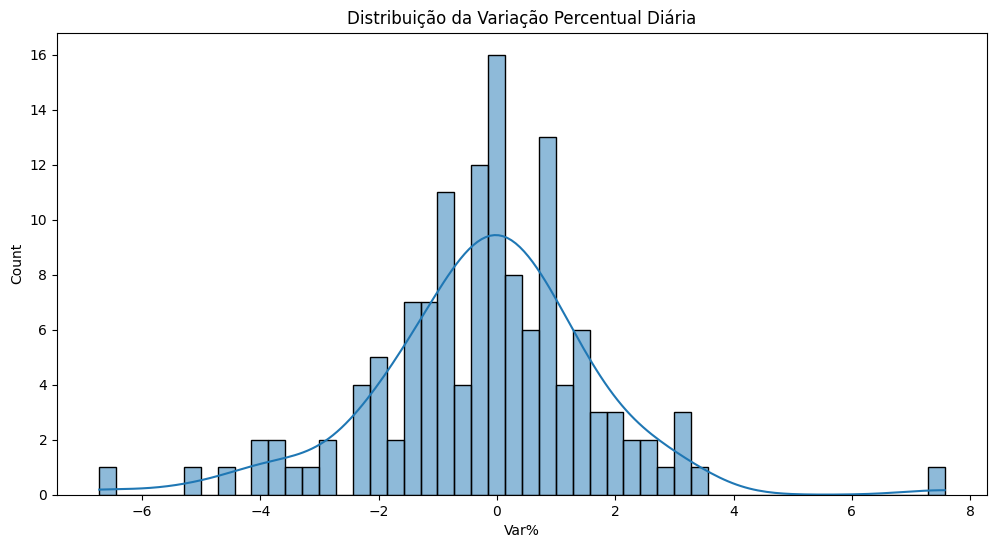

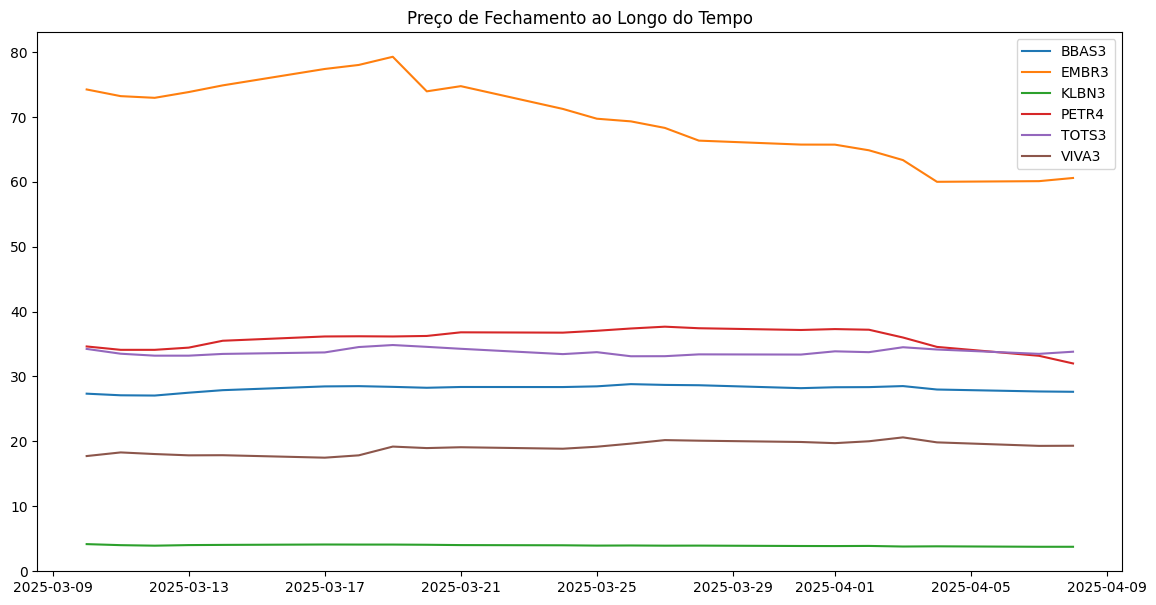

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

display(data.describe())

plt.figure(figsize=(12,6))
sns.histplot(data['Var%'], bins=50, kde=True)
plt.title('Distribuição da Variação Percentual Diária')
plt.show()

plt.figure(figsize=(14,7))

for ticker in tickers_files.keys():
    subset = data[data['Ticker'] == ticker]
    plt.plot(subset['Data'], subset['Último'], label=ticker)

plt.legend()

plt.title('Preço de Fechamento ao Longo do Tempo')
plt.show()

## 3. Pré-processamento e Feature Engineering

Essa etapa cria variáveis de defasagem (lags) para capturar o comportamento passado do ativo e define o alvo de previsão (alta ou baixa no dia seguinte). O aviso exibido é apenas informativo e não afeta o funcionamento do código

In [8]:
def add_lags(df, n_lags=3):
    for lag in range(1, n_lags+1):
        df[f'Var%_lag{lag}'] = df['Var%'].shift(lag)
        df[f'Último_lag{lag}'] = df['Último'].shift(lag)

    return df

data = data.groupby('Ticker', group_keys=False).apply(add_lags).reset_index(drop=True)
data = data.dropna()

# Criar coluna de target binária: 1 para alta, 0 para baixa
# (considerando 0 como neutro, pode ser removido se preferir)
data['Target'] = (data['Var%'] > 0).astype(int)

features = [col for col in data.columns if 'lag' in col]
target = 'Target'
data[features + [target]].head()


C:\Users\joaoo\AppData\Local\Temp\ipykernel_22552\22350052.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data = data.groupby('Ticker', group_keys=False).apply(add_lags).reset_index(drop=True)


,Var%_lag1,Último_lag1,Var%_lag2,Último_lag2,Var%_lag3,Último_lag3,Target
3,-0.16,27.05,-0.89,27.09,-0.32,27.34,1
4,1.63,27.49,-0.16,27.05,-0.89,27.09,1
5,1.42,27.88,1.63,27.49,-0.16,27.05,1
6,2.08,28.46,1.42,27.88,1.63,27.49,1
7,0.14,28.50,2.08,28.46,1.42,27.88,0


## 4. Divisão de Dados em Treino e Teste

Essa etapa separa os dados de cada ativo em treino e teste, respeitando a ordem temporal, para garantir que a avaliação do modelo seja realista e sem vazamento de informação.

In [11]:
def split_train_test(df, frac=0.8):
    idx = int(len(df)*frac)
    return df.iloc[:idx], df.iloc[idx:]

train = []
test = []
for ticker in tickers_files.keys():
    t, s = split_train_test(data[data['Ticker'] == ticker])
    train.append(t)
    test.append(s)
train = pd.concat(train)
test = pd.concat(test)

X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]

print('Exemplo de X_train:')
display(X_train.head())

print('Distribuição do target no treino:')
print(y_train.value_counts(normalize=True))

Exemplo de X_train:


,Var%_lag1,Último_lag1,Var%_lag2,Último_lag2,Var%_lag3,Último_lag3
3,-0.16,27.05,-0.89,27.09,-0.32,27.34
4,1.63,27.49,-0.16,27.05,-0.89,27.09
5,1.42,27.88,1.63,27.49,-0.16,27.05
6,2.08,28.46,1.42,27.88,1.63,27.49
7,0.14,28.50,2.08,28.46,1.42,27.88


Distribuição do target no treino:
Target
1    0.522222
0    0.477778
Name: proportion, dtype: float64


## 5. Treinamento e Avaliação de Modelos

Essa etapa treina e avalia três modelos de classificação diferentes — Random Forest, Regressão Logística e SVM — para prever se o ativo vai subir ou cair no próximo dia, usando as variáveis de defasagem como entrada. Para cada modelo, são exibidas métricas de desempenho (precisão, recall, f1-score) e a matriz de confusão, permitindo comparar a performance entre os algoritmos.

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print('Random Forest:')
print(classification_report(y_test, y_pred_rf))

print('Matriz de confusão:')
print(confusion_matrix(y_test, y_pred_rf))

Random Forest:
              precision    recall  f1-score   support

           0       0.50      0.25      0.33        16
           1       0.25      0.50      0.33         8

    accuracy                           0.33        24
   macro avg       0.38      0.38      0.33        24
weighted avg       0.42      0.33      0.33        24

Matriz de confusão:
[[ 4 12]
 [ 4  4]]


In [14]:
from sklearn.linear_model import LogisticRegression

# Regressão Logística
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
print('Logistic Regression:')
print(classification_report(y_test, y_pred_lr))
print('Matriz de confusão:')
print(confusion_matrix(y_test, y_pred_lr))

Logistic Regression:
              precision    recall  f1-score   support

           0       0.60      0.38      0.46        16
           1       0.29      0.50      0.36         8

    accuracy                           0.42        24
   macro avg       0.44      0.44      0.41        24
weighted avg       0.50      0.42      0.43        24

Matriz de confusão:
[[ 6 10]
 [ 4  4]]


In [15]:
from sklearn.svm import SVC

# SVM
svc = SVC(kernel='rbf', probability=True)
svc.fit(X_train, y_train)
y_pred_svc = svc.predict(X_test)
print('SVM:')
print(classification_report(y_test, y_pred_svc))
print('Matriz de confusão:')
print(confusion_matrix(y_test, y_pred_svc))

SVM:
              precision    recall  f1-score   support

           0       0.62      0.31      0.42        16
           1       0.31      0.62      0.42         8

    accuracy                           0.42        24
   macro avg       0.47      0.47      0.42        24
weighted avg       0.52      0.42      0.42        24

Matriz de confusão:
[[ 5 11]
 [ 3  5]]


## 6. Comparação dos Modelos

Essa etapa compara o desempenho dos três modelos (Random Forest, Regressão Logística e SVM) usando a métrica de acurácia, reunindo os resultados em uma tabela para facilitar a análise e escolha do melhor algoritmo

In [16]:
from sklearn.metrics import accuracy_score

results = pd.DataFrame({
    'Random Forest': [accuracy_score(y_test, y_pred_rf)],
    'Logistic Regression': [accuracy_score(y_test, y_pred_lr)],
    'SVM': [accuracy_score(y_test, y_pred_svc)]
}, index=['Acurácia'])

display(results)

,Random Forest,Logistic Regression,SVM
Acurácia,0.333333,0.416667,0.416667


## 7. Importância das Features (Random Forest)

Essa etapa avalia e visualiza a importância de cada variável de entrada (feature) para o modelo Random Forest, mostrando quais lags têm maior influência na previsão do movimento do ativo.

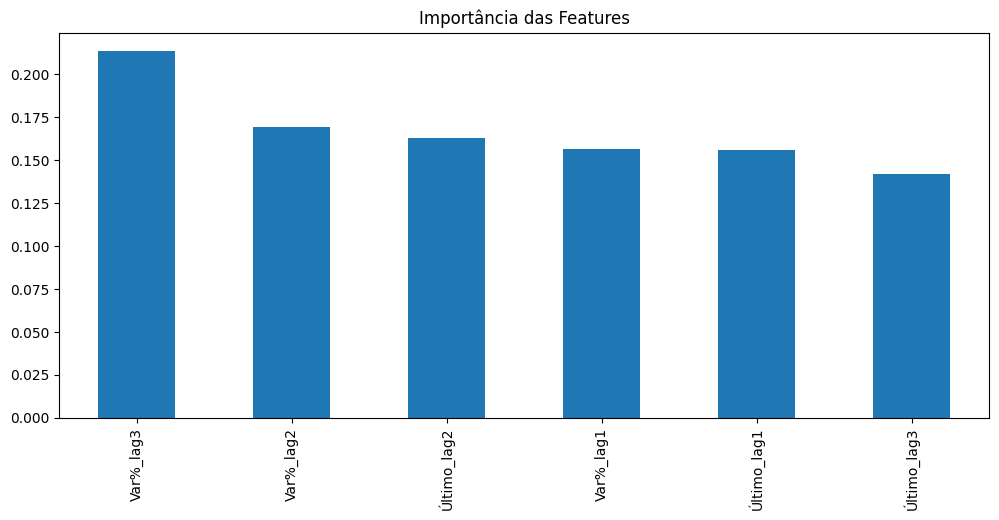

In [17]:
importances = rf.feature_importances_
feat_imp = pd.Series(importances, index=features).sort_values(ascending=False)
feat_imp.plot(kind='bar', figsize=(12,5), title='Importância das Features')
plt.show()

## 8. Salvando o Modelo Treinado

Essa etapa salva o modelo Random Forest treinado em um arquivo (model.pkl), permitindo que ele seja reutilizado futuramente sem a necessidade de re-treinamento.

In [18]:
import pickle

with open('model.pkl', 'wb') as f:
    pickle.dump(rf, f)
    
print('Modelo salvo como model.pkl')

Modelo salvo como model.pkl



## 9. Conclusão e Próximos Passos

Neste notebook, realizamos a classificação da direção da variação percentual diária de ações brasileiras, incluindo:

- Carregamento e limpeza robusta dos dados históricos.
- Análise exploratória e visualização dos dados.
- Feature engineering com lags e criação de target binário.
- Treinamento e avaliação de três modelos: Random Forest, Regressão Logística e SVM.
- Comparação quantitativa dos resultados.
- Análise de importância das features.
- Salvamento do modelo treinado para uso futuro.

**Próximos passos:**
- Testar outros algoritmos (ex: XGBoost, LightGBM).
- Realizar tuning de hiperparâmetros.
- Incluir mais features (ex: indicadores técnicos).
- Avaliar o modelo em dados mais recentes ou em produção.

*Este notebook serve como base para experimentação e pode ser expandido conforme a necessidade do projeto.*
